In [24]:
import warnings
warnings.filterwarnings('ignore')
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.models import Model

In [25]:
with open('skin.pkl', 'rb') as fp:
    data = pickle.load(fp)
#print (data.head(5))
data.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/home/jupyter/Input/ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[191, 153, 194], [191, 154, 198], [189, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/home/jupyter/Input/ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/home/jupyter/Input/ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[186, 126, 136], [190, 136, 149], [195, 137,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/home/jupyter/Input/ISIC_0025661.jpg,Benign keratosis-like lesions,2,"[[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/home/jupyter/Input/ISIC_0031633.jpg,Benign keratosis-like lesions,2,"[[[136, 91, 114], [148, 104, 127], [161, 117, ..."


In [26]:
X=data["image"]
Y=data['cell_type_idx']
x_train, x_test, y_train, y_test=train_test_split(X, Y, test_size=0.20,random_state=1, shuffle=True, stratify=Y)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.25, random_state = 1, shuffle=True, stratify=y_train)

In [27]:
train_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False, # randomly flip images
        rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)  

In [28]:
x_train=np.array(x_train.tolist())
x_validation=np.array(x_validation.tolist())

In [29]:
train_datagen.fit(x_train)
validation_datagen.fit(x_validation)

# build model

In [31]:
IMG_SHAPE = (75, 100, 3)

# Create the base model from the pre-trained model ResNet50
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [83]:
base_model.trainable = True
base_model.summary()
print (len(base_model.layers))
for layer in base_model.layers[:173]:
    layer.trainable = False

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 75, 100, 3)] 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 81, 106, 3)   0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 38, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 38, 50, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [84]:
model = tf.keras.Sequential([base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.8),
    #keras.layers.Dense(32, activation="relu"),
  keras.layers.Dense(7, activation='softmax')
])

In [85]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 3, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_12  (None, 2048)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 7)                 14343     
Total params: 23,602,055
Trainable params: 14,343
Non-trainable params: 23,587,712
_________________________________________________________________


In [86]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [87]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 3, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_12  (None, 2048)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 7)                 14343     
Total params: 23,602,055
Trainable params: 14,343
Non-trainable params: 23,587,712
_________________________________________________________________


In [88]:
history=model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=64),
                    steps_per_epoch=len(x_train) / 64, epochs=15,validation_data=validation_datagen.flow(x_validation, y_validation,batch_size=64),validation_steps=len(x_validation)/64)

Epoch 1/15
94/93 [==============================] - 28s 300ms/step - loss: 3.2975 - acc: 0.1558 - val_loss: 1.9740 - val_acc: 0.1518
Epoch 2/15
94/93 [==============================] - 16s 167ms/step - loss: 2.6931 - acc: 0.2616 - val_loss: 1.5349 - val_acc: 0.4353
Epoch 3/15
94/93 [==============================] - 16s 172ms/step - loss: 2.2859 - acc: 0.3565 - val_loss: 1.2396 - val_acc: 0.6450
Epoch 4/15
94/93 [==============================] - 16s 174ms/step - loss: 1.9932 - acc: 0.4367 - val_loss: 1.0574 - val_acc: 0.7014
Epoch 5/15
94/93 [==============================] - 16s 170ms/step - loss: 1.6910 - acc: 0.5285 - val_loss: 0.9496 - val_acc: 0.7229
Epoch 6/15
94/93 [==============================] - 16s 169ms/step - loss: 1.5220 - acc: 0.5696 - val_loss: 0.8799 - val_acc: 0.7339
Epoch 7/15
94/93 [==============================] - 16s 174ms/step - loss: 1.3328 - acc: 0.6319 - val_loss: 0.8338 - val_acc: 0.7414
Epoch 8/15
94/93 [==============================] - 16s 168ms/step - 

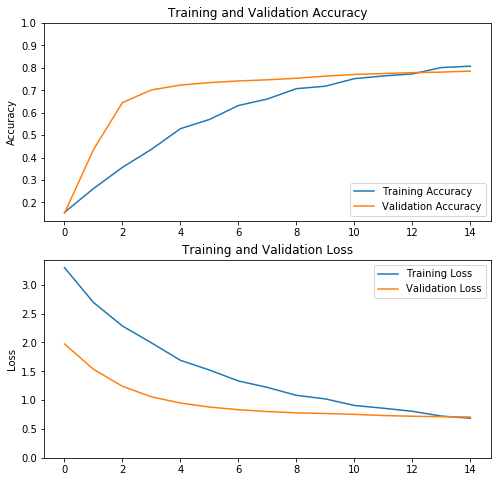

In [89]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()